In [16]:
import pandas as pd
data = pd.read_excel(r"C:\Users\Terry\Desktop\XGBoost.xlsx")
data["校园预制菜意向"] = data["校园预制菜意向"].map({1:1, 2:0}) # 1-是 2-否

In [17]:
data

,性别,受教育程度,饮食花销占比,下厨做菜的频率,是否吃过预制菜,购买预制菜的预算比例,是否考虑加工难度和便捷性,是否考虑价格,是否考虑菜品种类齐全,是否考虑保存时间,...,重要性_菜品营养丰富,重要性_储存条件简单,重要性_包装精美细致,重要性_价格,重要性_经常有促销活动,重要性_品牌知名度,重要性_食品安全性,重要性_产品的口感好种类多,情感指数,校园预制菜意向
0,2,3,2,3,1,3,1,1,1,1,...,5,5,5,4,4,3,1,1,0.646467,1
1,2,3,2,1,1,2,0,1,0,1,...,3,3,4,3,5,5,5,5,0.244434,1
2,1,3,2,4,1,1,0,1,0,1,...,5,5,3,5,3,3,5,3,0.487761,0
3,1,3,3,2,3,2,1,1,0,0,...,3,4,4,4,3,4,5,4,0.526233,1
4,2,3,2,2,1,3,1,1,0,1,...,3,4,3,4,4,4,5,4,0.409149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2,3,2,1,3,4,0,0,0,1,...,2,4,3,5,5,5,5,5,0.409149,1
163,2,3,3,1,1,2,0,1,0,1,...,4,4,4,4,4,4,4,4,0.409149,1
164,1,2,2,1,3,1,1,1,1,0,...,5,5,3,5,4,4,5,5,0.409149,1
165,1,3,3,2,2,2,1,0,0,1,...,2,3,2,1,2,2,2,2,0.709251,0


In [18]:
# 分离X Y
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

In [19]:
# 方差过滤
# 特征选择第一步：过滤常量和准常量特征
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
# 设置方差阈值为0，过滤常量特征
sel_constant = VarianceThreshold(threshold = 0.1)  # 选择方差＞0的特征，过滤掉方差<0.1的特征
sel_constant.fit(X)  # 计算方差，【注意】调用fit或fit_transform计算时df_data_copy会转换为ndarray类型
# 查询过滤的常量特征的数量
num_left_feature = sum(sel_constant.get_support())  # 方差＞0的特征，即剩余特征数
num_constant_feature = X.shape[1] - num_left_feature # 常量特征数 无常量特征
print('常量特征（需要剔除的）数量:', num_constant_feature)  # 常量特征数：
print('剩余特征数量:',num_left_feature)  # 剩余特征数：505
constant_colName_list = [ x for x in X.columns if x not in X.columns[sel_constant.get_support()] ]
print(constant_colName_list)

常量特征（需要剔除的）数量: 2
剩余特征数量: 29
['是否考虑包装美观', '情感指数']


<AxesSubplot:>

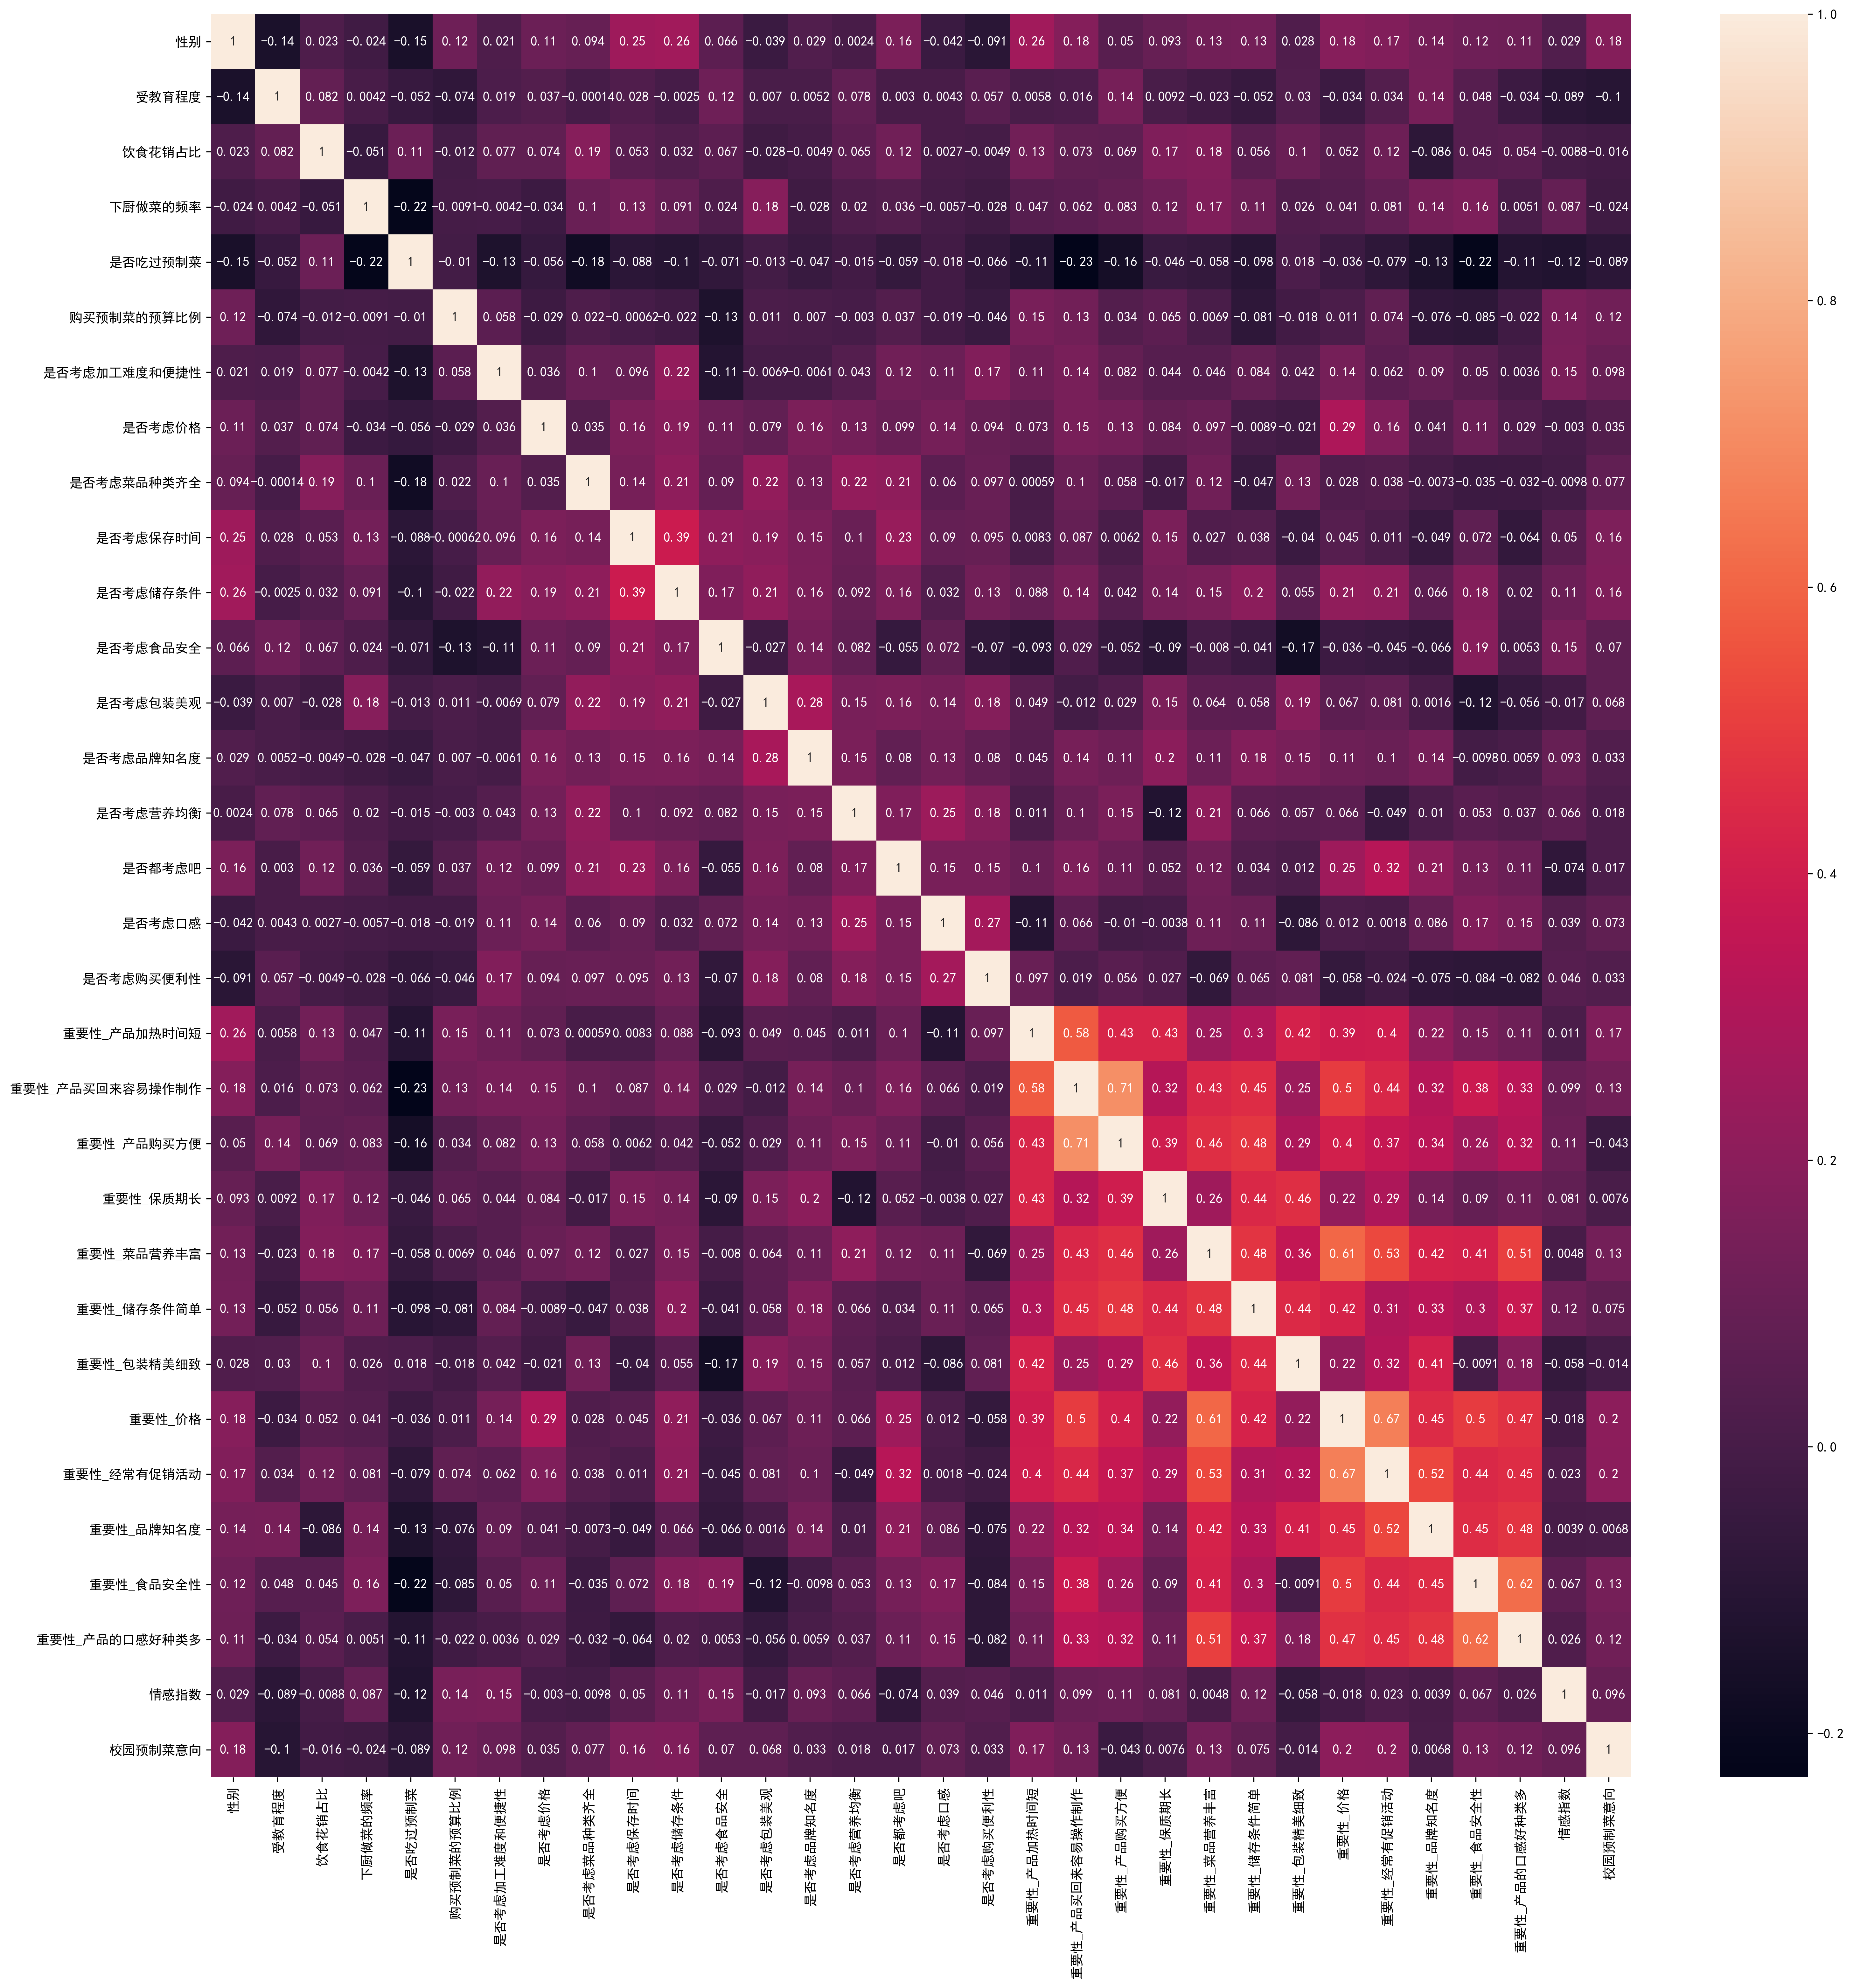

In [31]:
import seaborn as sns # 导seaborn包
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] # 设置图片正确显示中文
plt.rcParams['axes.unicode_minus'] = False # 设置图片正确显示负数
plt.figure(figsize=(24,24),dpi=300) #设置图片大小和分辨率
sns.heatmap(data.corr(), annot=True) # 绘图

In [32]:
X = X.drop(constant_colName_list, axis = 1)

In [34]:
# 特征选择第二步：去掉相关性强的冗余特征
def correlation(data, threshold, method = "pearson"):
    
    # 定义一个集合放置高度相关的变量的名称，利用集合元素不重复的特性
    col_corr = set()
    
    # 使用相关性系数，默认皮尔逊相关
    corr_matrix = data.corr(method = method)
    
    # 已将变量按重要性降序排序，逐行逐元素判断相关性系数是否大于阈值，如果大于则将重要性较小的变量名称放入集合中
    # corr_matrix.columns[i]对于重要程度小的变量名称
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

# 分别调用correlation函数求出相关性超过阈值0.9的变量
high_pearson_list = list(correlation(X, 0.90, method = "pearson"))
high_spearman_list = list(correlation(X, 0.90, method = "spearman"))
high_corr_list = list(set(high_pearson_list + high_spearman_list))

print(high_corr_list)

[]


In [35]:
X = X.drop(high_corr_list, axis = 1)

In [69]:
# 特征选择重要性：随机森林模型 评估特重要性
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# 输入数据准备
X = X
Y = Y #语音通话整体满意度  改动这里就好了！！！！！！！！！！！！！！！！！！！！！！！ Y1 Y2 Y3 Y4

# 记录起始时间
t0 = time()

# 模型构建
forest = RandomForestClassifier(random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 0)
sc = StandardScaler() 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
model = forest.fit(X_train, y_train)

# 统计模型建立时间
print("done in %0.3fs"%(time() - t0))

# 输出特征重要性
importances = forest.feature_importances_
print(importances.shape)

# 特征重要性成dataframe并排序
feature_importance = pd.DataFrame(list(importances),columns = ["importance"],index = X.columns)
feature_importance_sorted = feature_importance.sort_values(by = "importance", ascending = False)

#特征重要性柱状图 - plotly
import plotly.express as px
#绘制条形图
fig = px.bar(feature_importance_sorted[:20],# 前20重要特征
            x = feature_importance_sorted[:20].index, 
            y = "importance",
            color="importance",
            text = "importance",
            title = "影响学生选择校园预制菜的特征重要性排序",
            text_auto='.2')
fig.update_traces(textposition='outside')
fig.update_xaxes(title_text='')
fig.show()

done in 0.068s
(29,)


In [39]:
feature_importance_sorted

,importance
重要性_保质期长,0.058792
重要性_产品的口感好种类多,0.052688
重要性_经常有促销活动,0.052637
购买预制菜的预算比例,0.049778
重要性_产品加热时间短,0.048279
下厨做菜的频率,0.048022
重要性_包装精美细致,0.045870
饮食花销占比,0.044086
重要性_菜品营养丰富,0.043234
重要性_价格,0.039221


In [40]:
# 分类问题评价指标封装
def model_evaluation(model, modeltype = ""):
    
    """
    以DataFrame类型返回回归模型的五种评价指标
    
    参数:
        model:输入的预测模型，model是fit方法之后赋值的变量
        modeltype:模型类型（字符串）
        
    返回值:
        train_evaluation_df：验证集模型评价指标的DataFrame
        test_evaluation_df: 测试集模型评价指标的DataFrame
    """
    
    # 导入需要的包,以防函数外未导入
    from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score,log_loss
    import pandas as pd
    
    # 对于分类模型，有一些模型输入变量需要标准化
    if modeltype in ["KNN","LogisticRegression","SVM","MLP"]:
        y_pred = model.predict(X_test_std)
        y_train_pred = model.predict(X_train_std)
    else:
        y_pred = model.predict(X_test) 
        y_train_pred = model.predict(X_train)
    
    
    # 评价指标汇总，测试集
    test_evaluation_dict = { "Accuracy":[accuracy_score(y_test,y_pred)],# 精度
                        "precision":[precision_score(y_test, y_pred)],# 准确率/查准率
                        "recall":[recall_score(y_test, y_pred)],# 召回率/查全率
                        "F1":[f1_score(y_test, y_pred)],# F1分数
                        "log_loss":[log_loss(y_test,y_pred)],# 对数损失
                        "ROC_AUC":[roc_auc_score(y_test,y_pred)],# ROC曲线下面积
                        "data_type":["test"]
                      }

    # 评价指标汇总，训练集
    train_evaluation_dict = { "Accuracy":[accuracy_score(y_train,y_train_pred)],# 精度
                        "precision":[precision_score(y_train,y_train_pred)],# 准确率/查准率
                        "recall":[recall_score(y_train,y_train_pred)],# 召回率/查全率
                        "F1":[f1_score(y_train,y_train_pred)],# F1分数
                        "log_loss":[log_loss(y_train,y_train_pred)],# 对数损失
                        "ROC_AUC":[roc_auc_score(y_train,y_train_pred)],# ROC曲线下面积
                        "data_type":["train"]
                      }
    
    # 将评价指标字典转为DataFrame，便于呈现和后期转存
    test_evaluation_df = pd.DataFrame(test_evaluation_dict,index = [modeltype])
    train_evaluation_df = pd.DataFrame(train_evaluation_dict,index = [modeltype])
    
    # 返回两个评价指标DataFrame
    return train_evaluation_df,test_evaluation_df

In [41]:
# 混淆矩阵画图
def cm_plot(modeltype = ""):
    """
    绘制混淆矩阵图
    
    参数:
        modeltype:模型类型（字符串）
        ADMET：ADMET性质名称（字符串）
    """
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    plot = skplt.metrics.plot_confusion_matrix(y_test,y_pred)
    plt.title("Model: " + modeltype)
    plt.show()

In [72]:
# ROC曲线绘制
def roc_plot(modeltype = ""):
    
    """
    绘制ROC曲线
    
    参数:
        modeltype:模型类型（字符串）
        ADMET：ADMET性质名称（字符串）
    """
    
    # 导入需要的包
    import plotly.express as px
    from sklearn.metrics import roc_curve,auc
    import matplotlib.pyplot as plt

    fpr,tpr,thresholds  = roc_curve(y_test,y_pred)

    # 绘制面积图
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f}) ' + "  |  Model: " + modeltype,
        labels=dict(x='False Positive Rate', 
                    y='True Positive Rate'),
        width=700, height=500)
    # 添加理论线 黑色虚线
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1)
    
    # 更新图表样式
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

In [43]:
# PR曲线绘制
def pr_plot(modeltype = ""):
    
    """
    绘制PR曲线
    
    参数:
        modeltype:模型类型（字符串）
        ADMET：ADMET性质名称（字符串）
    """
    
    # 导入需要的包
    import plotly.express as px
    from sklearn.metrics import precision_recall_curve, auc, recall_score, precision_score
    
    precision, recall, thresholds = precision_recall_curve(y_train, y_score)
    
    # 绘制面积图
    fig = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUC={auc(recall, precision):.4f}) '+ "  |  Model: " + modeltype,
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500)
    # 添加理论线 黑色虚线
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1)
    
    # 更新图表样式
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

In [46]:
# XGBoost

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.8,random_state=1)


import xgboost as xgb
xgb = xgb.XGBClassifier()
model = xgb.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_score = model.predict_proba(X_train)[:,1]

xgb_train, xgb_test  = model_evaluation(model, modeltype = "XGBoost")
xgb_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
XGBoost,0.567164,0.582677,0.936709,0.718447,14.949936,0.486536,test


In [73]:
# 逻辑回归 LogisticRegression

# 切分训练数据和测试数据
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

# 标准化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
# 标准化后的数据
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 逻辑回归建模
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1,max_iter=10000)
model = lr.fit(X_train_std,y_train)

# 预测
y_pred = model.predict(X_test_std)
y_train_pred = model.predict(X_train_std)
y_score = model.predict_proba(X_train_std)[:,1]

# 模型评价指标展示
lr_train, lr_test  = model_evaluation(model, modeltype = "LogisticRegression")
lr_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
LogisticRegression,0.705882,0.710526,0.870968,0.782609,10.158636,0.660484,test


In [74]:
roc_plot(modeltype = "LogisticRegression")

In [75]:
pr_plot(modeltype = "LogisticRegression")

In [78]:
pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


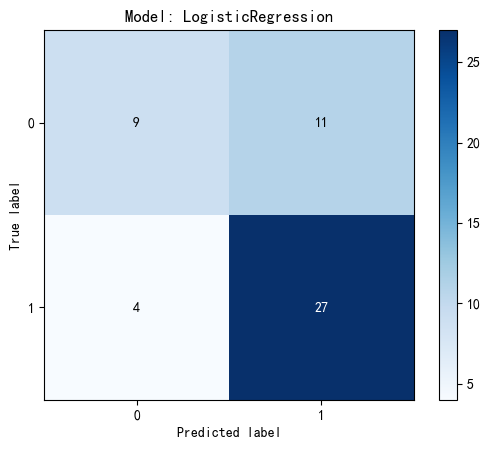

In [79]:
# 混淆矩阵
cm_plot(modeltype = "LogisticRegression")

In [57]:
#SVM

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


from sklearn import svm
svm = svm.SVC(kernel='linear',probability=True)
model = svm.fit(X_train_std,y_train)

y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)
y_score = model.predict_proba(X_train_std)[:,1]

svm_train, svm_test  = model_evaluation(model, modeltype = "SVM")
svm_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
SVM,0.647059,0.666667,0.83871,0.742857,12.19036,0.594355,test


In [58]:
#KNN

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model = knn.fit(X_train_std,y_train)

y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)
y_score = model.predict_proba(X_train_std)[:,1]

knn_train, knn_test  = model_evaluation(model, modeltype = "KNN")
knn_test

E:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

E:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

E:\Anaconda3\lib\site-pack

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
KNN,0.5,0.552632,0.84,0.666667,17.269712,0.42,test


In [60]:
#决策树

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

from sklearn import tree
dt = tree.DecisionTreeClassifier()
model = dt.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_score = model.predict_proba(X_train)[:,1]

dt_train, dt_test  = model_evaluation(model, modeltype = "Decision Tree")
dt_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
Decision Tree,0.470588,0.571429,0.516129,0.542373,18.285423,0.458065,test


In [61]:
# 高斯朴素贝叶斯

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model = gnb.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_score = model.predict_proba(X_train)[:,1]

gnb_train, gnb_test  = model_evaluation(model, modeltype = "GaussianNB")
gnb_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
GaussianNB,0.666667,0.675,0.870968,0.760563,11.513129,0.610484,test


In [62]:
# AdaBoost

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()
model = adb.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_score = model.predict_proba(X_train)[:,1]

adb_train, adb_test  = model_evaluation(model, modeltype = "AdaBoost")
adb_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
AdaBoost,0.607843,0.657143,0.741935,0.69697,13.544806,0.570968,test


In [63]:
# Random Forest

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
model = rf.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_score = model.predict_proba(X_train)[:,1]

rf_train, rf_test  = model_evaluation(model, modeltype = "Random Forest")
rf_test

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
Random Forest,0.509804,0.571429,0.774194,0.657534,16.931055,0.437097,test


In [64]:
# MLP

# 切分训练数据和测试数据
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier()
model = mlpc.fit(X_train_std,y_train)

y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)
y_score = model.predict_proba(X_train_std)[:,1]

mlp_train,mlp_test  = model_evaluation(model, modeltype = "MLP")
mlp_test

E:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
MLP,0.568627,0.615385,0.774194,0.685714,14.899315,0.512097,test


In [66]:
model_test = pd.concat([lr_test, 
                         svm_test, 
                         knn_test, 
                         dt_test,
                         gnb_test,
                         adb_test,
                         rf_test,
                         xgb_test,
                         mlp_test],axis = 0)
model_test.style.background_gradient(cmap = "Blues")

,Accuracy,precision,recall,F1,log_loss,ROC_AUC,data_type
LogisticRegression,0.705882,0.710526,0.870968,0.782609,10.158636,0.660484,test
SVM,0.647059,0.666667,0.838710,0.742857,12.190360,0.594355,test
KNN,0.500000,0.552632,0.840000,0.666667,17.269712,0.420000,test
Decision Tree,0.470588,0.571429,0.516129,0.542373,18.285423,0.458065,test
GaussianNB,0.666667,0.675000,0.870968,0.760563,11.513129,0.610484,test
AdaBoost,0.607843,0.657143,0.741935,0.696970,13.544806,0.570968,test
Random Forest,0.509804,0.571429,0.774194,0.657534,16.931055,0.437097,test
XGBoost,0.567164,0.582677,0.936709,0.718447,14.949936,0.486536,test
MLP,0.568627,0.615385,0.774194,0.685714,14.899315,0.512097,test
